In [1]:
# !pip install parfit

In [25]:
import parfit.parfit as pf
from parfit import bestFit
from parfit.fit import *
from parfit.score import *
from parfit.plot import *
from parfit.crossval import *

In [34]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression
from collections import Counter
from wordcloud import WordCloud

In [4]:
df = pd.read_csv("twitter.csv", encoding = "utf-8")

In [5]:
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [6]:
df.category.value_counts()

 1.0    72250
 0.0    55213
-1.0    35510
Name: category, dtype: int64

In [7]:
df.isna().sum()

clean_text    4
category      7
dtype: int64

In [8]:
df = df.dropna().copy()

In [9]:
df_subset = df.groupby("category").sample(n = 35000, random_state = 1)
df_subset = df_subset.sample(frac = 1).reset_index(drop=True).copy()

In [10]:
df_subset.head(10)

,clean_text,category
0,modi’ three foreign policy wins carnegie endow...,1.0
1,now\nindia and indians are getting what they w...,-1.0
2,\ntodays team modi public events addressed 103...,0.0
3,life highway after modi and yogi,0.0
4,wishful thinking and dream that seems highly p...,1.0
5,but one can never deny that with its massive l...,0.0
6,dear you are not going india thats why you hav...,1.0
7,shadow assessment the years seeks another term...,0.0
8,their problem not successful asat test but the...,-1.0
9,those who joined twitter 2019 itself may polit...,0.0


In [11]:
vocab = [word for sent in df_subset["clean_text"].values for word in sent.split()]
freq = Counter(vocab)
freq_sorted = [word for word, frequency in sorted(freq.items(), key=lambda item: item[1], reverse = True)]

In [12]:
border = len(freq_sorted)*0.05
most_least_freq_words = freq_sorted[:int(border)] + freq_sorted[-int(border):]

In [13]:
pos = df_subset.groupby('category').clean_text.apply(' '.join).str.split()[1]
neu = df_subset.groupby('category').clean_text.apply(' '.join).str.split()[0]
neg = df_subset.groupby('category').clean_text.apply(' '.join).str.split()[-1]

In [14]:
cloud = WordCloud(stopwords = most_least_freq_words)
cld_pos = cloud.generate(" ".join(pos))

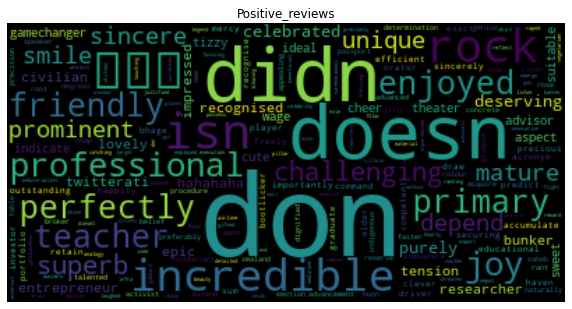

In [15]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.imshow(cld_pos, interpolation='bilinear')
plt.axis("off")
plt.title("Positive_reviews")
plt.show()

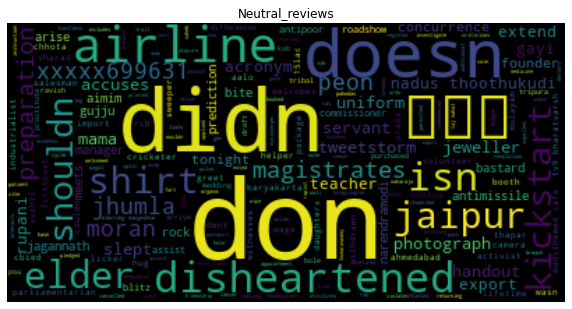

In [16]:
%matplotlib inline
cld_neu = cloud.generate(" ".join(neu))
plt.figure(figsize=(10, 10))
plt.imshow(cld_neu, interpolation='bilinear')
plt.axis("off")
plt.title("Neutral_reviews")
plt.show()

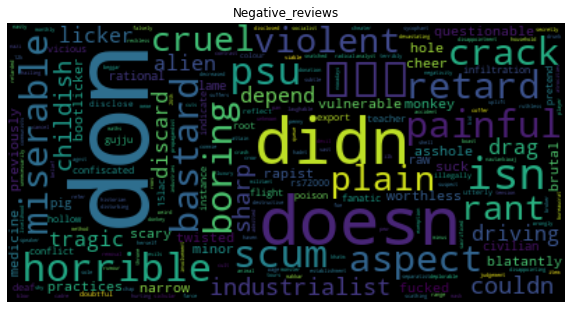

In [17]:
%matplotlib inline
cld_neg = cloud.generate(" ".join(neg))
plt.figure(figsize=(10, 10))
plt.imshow(cld_neg, interpolation='bilinear')
plt.axis("off")
plt.title("Negative_reviews")
plt.show()

In [29]:
tf = TfidfVectorizer(ngram_range = (1,2))

In [14]:
X = df_subset["clean_text"].values
y = df_subset["category"].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.9, random_state = 1)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.85, random_state = 1)

Since the data is in textual format, it is required to transform it ot vector format before fitting. There are two vectorizers I will be uing here to see which one give better results

In [ ]:
params = {
    "alpha": [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]
}

paramGrid = ParameterGrid(params)

best_model, best_score, all_models, all_scores = pf.bestFit(OneVsRestClassifier(SGDClassifier(max_iter = 1000, loss = "log", n_jobs = -1)), 
                        paramGrid, tf.fit_transform(X_train), y_train, tf.transform(X_val), y_val, 
                        metric=roc_auc_score, greater_is_better=True)

In [ ]:
pipe_tf_bayes = Pipeline([("tf", TfidfVectorizer(ngram_range = (1,2))), 
                          ("clf", MultinomialNB())
    
])

In [21]:
pipe_tf_bayes.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [22]:
pipe_tf_bayes.score(X_test, y_test)

0.6972857142857143

In [23]:
print(classification_report(pipe_tf_bayes.predict(X_test), y_test))

              precision    recall  f1-score   support

        -1.0       0.88      0.61      0.72     10098
         0.0       0.46      0.91      0.61      3515
         1.0       0.75      0.72      0.74      7387

    accuracy                           0.70     21000
   macro avg       0.70      0.74      0.69     21000
weighted avg       0.76      0.70      0.71     21000



In [26]:
pipe_cv_bayes = Pipeline([("cv",  CountVectorizer(ngram_range=(1,2), binary=True)), 
                          ("clf", MultinomialNB())
    
])

In [27]:
pipe_cv_bayes.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(binary=True, ngram_range=(1, 2))),
                ('clf', MultinomialNB())])

In [28]:
pipe_cv_bayes.score(X_test, y_test)

0.684047619047619

In [29]:
print(classification_report(pipe_cv_bayes.predict(X_test), y_test))

              precision    recall  f1-score   support

        -1.0       0.86      0.61      0.71      9859
         0.0       0.43      0.91      0.58      3239
         1.0       0.77      0.68      0.72      7902

    accuracy                           0.68     21000
   macro avg       0.68      0.74      0.67     21000
weighted avg       0.76      0.68      0.70     21000



The MultinomialNB is not doing very good, yet it is clear now that

In [217]:
pipe_sgd = Pipeline([("cv",  CountVectorizer(ngram_range=(1,2), binary=True)),
                    ('tfidf', TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-5, random_state=1506, max_iter=5, tol=None)),
               ])

In [218]:
pipe_sgd.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(binary=True, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=1e-05, max_iter=5, random_state=1506,
                               tol=None))])

In [219]:
pipe_sgd.score(X_test, y_test)

0.9145238095238095

__Logistic Regression__

In [30]:
pipe_cv_log = Pipeline([("cv",  CountVectorizer(binary=True, ngram_range=(1,2))), 
                        ("clf", LogisticRegression(C = 100, solver = "liblinear"))
    
])

In [31]:
pipe_cv_log.fit(X_train, y_train)

Pipeline(steps=[('cv', CountVectorizer(binary=True, ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=100, solver='liblinear'))])

In [32]:
accuracy_score(pipe_cv_log.predict(X_test), y_test)

0.9261428571428572

With TF-IDF

In [33]:
pipe_tf_log = Pipeline([("tf", TfidfVectorizer(ngram_range = (1,2))), 
                        ("clf", LogisticRegression(C = 100, solver = "liblinear"))
    
])

In [34]:
pipe_tf_log.fit(X_train, y_train)

Pipeline(steps=[('tf', TfidfVectorizer(ngram_range=(1, 2))),
                ('clf', LogisticRegression(C=100, solver='liblinear'))])

In [35]:
accuracy_score(pipe_tf_log.predict(X_test), y_test)

0.9144285714285715

In [36]:
confusion_matrix(pipe_tf_log.predict(X_test), y_test)

array([[6351,  287,  460],
       [ 251, 6498,  234],
       [ 412,  153, 6354]], dtype=int64)

In [37]:
print(classification_report(pipe_tf_log.predict(X_test), y_test))

              precision    recall  f1-score   support

        -1.0       0.91      0.89      0.90      7098
         0.0       0.94      0.93      0.93      6983
         1.0       0.90      0.92      0.91      6919

    accuracy                           0.91     21000
   macro avg       0.91      0.91      0.91     21000
weighted avg       0.91      0.91      0.91     21000

